# 

In [1]:
#$ Imports
import os
import sys
import json
from datetime import datetime
import itertools

import random
import numpy as np
import scipy as sc
import pandas as pd
import xarray as xr
import cftime
from dask.diagnostics import ProgressBar
from tqdm import tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cmocean as cmo

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl

import utils
from utils import settings

with open("~/s2s/paths.json") as paths_json:
    PATHS = json.load(paths_json)
with open("~/s2s/globals.json") as globals_json:
    GLOBALS = json.load(globals_json)

plt.style.use('bmh')

In [2]:
plt.rcParams['mathtext.fontset'] = 'custom'

In [3]:
def get_data(tau, icoord):
    lat, lon = utils.helpers.get_lat_lon_from_icoord(icoord)
    path = os.path.join(PATHS['s2s_predictions'], f'tau_{tau}')
    y_scaler = xr.open_dataset(os.path.join(path, 'y_standardizer.nc'))
    residual_scaler = xr.open_dataset(os.path.join(path, 'residual_standardizer.nc'))
    
    target_z = xr.open_dataarray(os.path.join(path, 'target.nc'))
    pred_mean_z = xr.open_dataarray(os.path.join(path, 'pred_mean.nc'))
    pred_logvar_z = xr.open_dataarray(os.path.join(path, 'pred_logvar.nc'))
    
    # Select location
    y_scaler = y_scaler.sel(lat=lat, lon=lon, method='nearest')
    residual_scaler = residual_scaler.sel(lat=lat, lon=lon, method='nearest')
    pred_mean_z = pred_mean_z.sel(lat=lat, lon=lon, method='nearest')
    pred_logvar_z = pred_logvar_z.sel(lat=lat, lon=lon, method='nearest')
    target_z = target_z.sel(lat=lat, lon=lon, method='nearest')
    
    # Unstandardize
    target = utils.processing.unstandardize(target_z, y_scaler)
    pred_mean = utils.processing.unstandardize(pred_mean_z, y_scaler)
    pred_std_z = np.sqrt(np.exp(pred_logvar_z))
    pred_std_z = utils.processing.unstandardize(pred_std_z, residual_scaler)
    pred_std = y_scaler['std'] * pred_std_z

    # Damped persistence predictions
    dp_darray_z = xr.open_dataarray(os.path.join(path, 'dp_pred.nc'))
    dp_darray_z = dp_darray_z.sel(lat=lat, lon=lon, method='nearest')
    dp_pred = utils.processing.unstandardize(dp_darray_z, y_scaler)

    return target, pred_mean, pred_std, dp_pred

In [4]:
def get_mae_by_confidence_data(target, pred_mean, pred_std, bins=10):
    sort_indices = np.argsort(pred_std.values)[::-1]
    N = len(sort_indices)
    alphas = np.linspace(0, 1, N)  # Confidence levels
    sorted_stds = pred_std.values[sort_indices]
    # Sorted MAE
    abs_errors = np.abs(target.values - pred_mean.values)[sort_indices]
    mae_binned = np.empty(bins)
    for i in range(bins):
        mae_binned[i] = abs_errors[int(N*i/bins):int(N*(i+1)/bins)].mean()
    alpha_coarse = np.arange(0, 1, 1/bins) + 0.5/bins
    
    sorted_stds = xr.DataArray(sorted_stds, coords={'alpha': alphas})
    mae_binned = xr.DataArray(mae_binned, coords={'alpha': alpha_coarse})
    return sorted_stds, mae_binned

In [10]:
icoords = [4710, 3282]

bins = 10
base_blue = np.array(mpl.colors.to_rgb('C0'))
base_red = np.array(mpl.colors.to_rgb('C1'))

dark_blue = tuple(base_blue * 0.75)
dark_red = tuple(base_red * 0.75)

light_blue = base_blue + 0.25*(1 - base_blue)
light_red = base_red + 0.25*(1 - base_red)

$WORK/conda-envs/s2s/lib/python3.11/site-packages/matplotlib/lines.py:1205: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  neq = current != val
$WORK/conda-envs/s2s/lib/python3.11/site-packages/matplotlib/lines.py:1205: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  neq = current != val


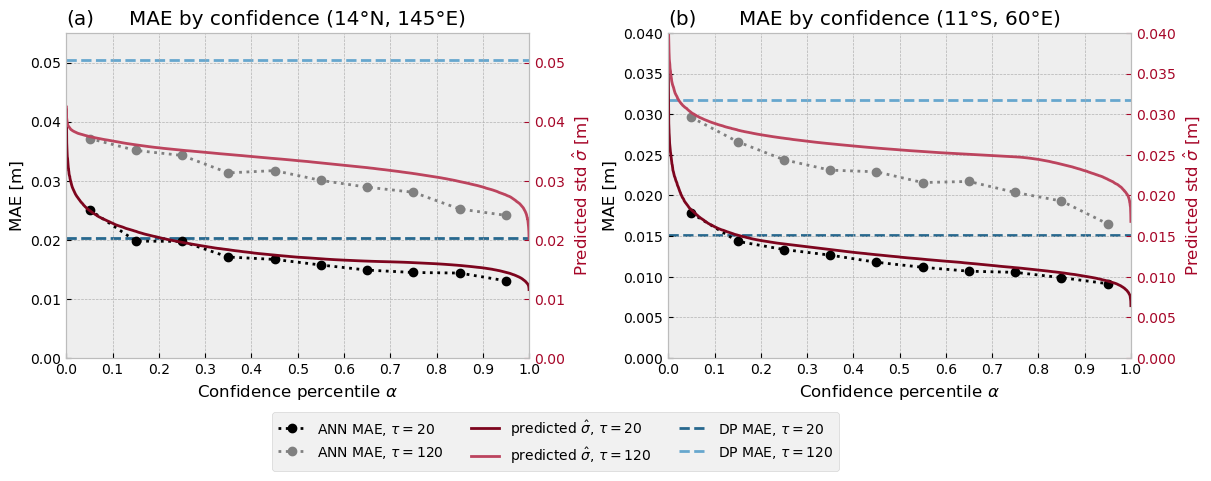

In [11]:
fig, axes = plt.subplot_mosaic(
    [['a', 'b']],
    figsize=(12,4),
    layout='constrained'
)

for icoord, label0 in zip(icoords, ['a', 'b']):
    lat, lon = utils.helpers.get_lat_lon_from_icoord(icoord)
    lat, lon = np.round(lat), np.round(lon)
    ax_r = axes[label0].twinx()
    ax_r.grid(False)
    
    target, pred_mean, pred_std, dp_pred = get_data(tau=20, icoord=icoord)
    sorted_stds, mae_binned = get_mae_by_confidence_data(target, pred_mean, pred_std)

    dp_mae = np.abs(target - dp_pred).mean().item()
    
    mae_binned.plot(ax=axes[label0], color='k', marker='o', ls=':', zorder=3)
    axes[label0].plot([0, 1], [dp_mae, dp_mae], color=dark_blue, ls='--', zorder=1)
    sorted_stds.plot(ax=ax_r, color=dark_red)
    
    target, pred_mean, pred_std, dp_pred = get_data(tau=120, icoord=icoord)
    sorted_stds, mae_binned = get_mae_by_confidence_data(target, pred_mean, pred_std)
    dp_mae = np.abs(target - dp_pred).mean().item()
    
    mae_binned.plot(ax=axes[label0], color='gray', marker='o', ls=':', zorder=3)
    axes[label0].plot([0, 1], [dp_mae, dp_mae], color=light_blue, ls='--', zorder=1)
    sorted_stds.plot(ax=ax_r, color=light_red)

    if lat >= 0:
        title = f'MAE by confidence ({int(lat)}\u00b0N, {int(lon)}\u00b0E)'
    else:
        title = f'MAE by confidence ({-int(lat)}\u00b0S, {int(lon)}\u00b0E)'
    
    axes[label0].set(
        xlabel=r'Confidence percentile $\alpha$',
        ylabel='MAE [m]',
        xlim=(0,1),
        xticks=np.linspace(0,1,bins+1),
        title=title
    );
    
    ax_r.tick_params(axis='y', colors=base_red)
    ax_r.set(ylabel=r'Predicted std $\hat{\sigma}$ [m]')
    ax_r.tick_params(axis='y', colors=base_red, labelleft=False)
    ax_r.yaxis.label.set_color(base_red)
    
    for ax in [axes[label0], ax_r]:
        if label0 == 'a':
            ax.set(ylim=(0,0.055))
        else:
            ax.set(ylim=(0,0.04))

for label, ax in axes.items():
    ax.set_title(f"({label})", loc='left')

axes['b'].plot([], color='k', marker='o', ls=':', label=r'ANN MAE, $\tau=20$')
axes['b'].plot([], color='gray', marker='o', ls=':', label=r'ANN MAE, $\tau=120$')
axes['b'].plot([], color=dark_red, label=r'predicted $\hat{\sigma}$, $\tau=20$')
axes['b'].plot([], color=light_red, label=r'predicted $\hat{\sigma}$, $\tau=120$')
axes['b'].plot([], color=dark_blue, ls='--',label=r'DP MAE, $\tau=20$')
axes['b'].plot([], color=light_blue, ls='--',label=r'DP MAE, $\tau=120$')

fig.legend(ncols=3, bbox_to_anchor=(0.70, 0))
plt.savefig('mae_by_confidence.pdf', dpi=300, bbox_inches='tight')